In [1]:
from google.colab import drive
# Importer le package nécessaire
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt_tab')

from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

from wordcloud import WordCloud
import re
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import string

#lier Google Drive personnel au système de fichiers virtuel du notebook
drive.mount('/content/drive')
#Chemin d'accès au fichier Parquet compressé
chemin_fichier = '/content/drive/MyDrive/df.parquet.gzip'
#Charger des données d'un fichier Parquet dans un DataFrame
df = pd.read_parquet(chemin_fichier)
df.shape #(320000, 3)

#Calculer le nombre de mots brut
df["easyocr_text_nbr"] = df["easyocr_text"].apply(len)
#Supprimer les lignes vides
#Nous avons extrait des textes 50 000 images soit  15% des 320 000 images d'entraînement
df = df[df['easyocr_text'].apply(len) > 0].copy()
df.shape#(49968, 4)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


Mounted at /content/drive


(49968, 4)

In [2]:
df.head()

,file_name,label,easyocr_text,easyocr_text_nbr
0,imagesq/q/o/c/qoc54c00/80035521.tif,15,"[~Conillard, MEMORANDUM, May, 12 ,, 1986, Heck...",54
1,imagese/e/w/c/ewc23d00/513280028.tif,1,"[Tod? 0~DZ, DOCUHENT_CLEARANCE_SHEEL, (For, Or...",89
2,imagesw/w/b/t/wbt26e00/2053453161.tif,7,"[CIGBRELIE, SPECLELCALLON, CABARRUS, CountY, E...",157
3,imagesm/m/k/m/mkm05e00/2040792992_2040792994.tif,10,"[LEO BURNETT U.S.4., nivsion or Lco, ILHY, cuk...",82
4,imageso/o/e/x/oex80d00/522787731+-7732.tif,3,"[W, 8, H, K, 0, 6, , 0, R, 1, 8, 11, 1, , 5, 0...",19


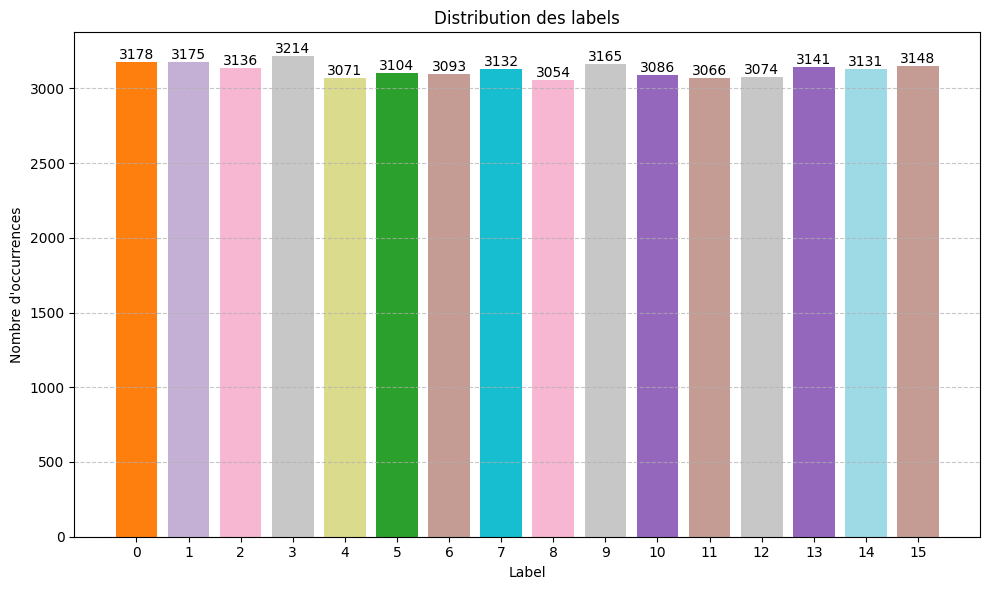

In [3]:
import random

# Convertir la colonne 'label' en type entier
df['label'] = df['label'].astype(int)

label_counts = df['label'].value_counts().sort_index()

#Créer l'histogramme : Distribution des Labels
plt.figure(figsize=(10, 6))  # Taille de la figure pour une meilleure lisibilité

# Générer des couleurs aléatoires pour chaque barre
colors = [plt.cm.tab20(random.randint(0, 19)) for _ in range(len(label_counts))]

bars = plt.bar(label_counts.index, label_counts.values, color=colors)

# Ajouter des titres et des labels
plt.title("Distribution des labels")
plt.xlabel("Label")
plt.ylabel("Nombre d'occurrences")

# Afficher le nombre au-dessus de chaque barre
for i, v in enumerate(label_counts.values):
    plt.text(label_counts.index[i], v + 0.5, str(v), ha='center', va='bottom', fontsize=10)

plt.xticks(np.arange(0, 16, 1))  # Affiche tous les entiers de 0 à 15

plt.grid(axis='y', linestyle='--', alpha=0.7)  # Ajoute une grille horizontale
plt.tight_layout()  # Ajuste la mise en page
plt.show()

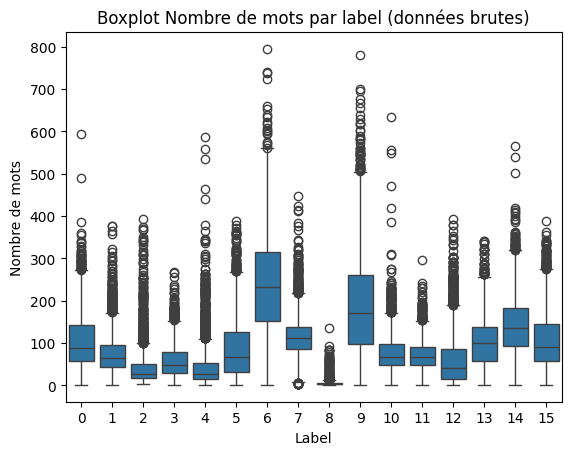

Statistiques des données brutes 
         count        mean         std  min    25%    50%     75%    max
label                                                                  
0      3178.0  105.211139   64.616730  1.0   57.0   88.0  143.00  595.0
1      3175.0   76.164094   47.457046  1.0   44.0   65.0   95.50  376.0
2      3136.0   41.520408   43.414697  2.0   17.0   27.0   50.25  394.0
3      3214.0   56.471375   38.071880  1.0   28.0   48.0   78.00  268.0
4      3071.0   44.379681   53.263060  1.0   14.0   26.0   52.00  586.0
5      3104.0   87.562178   70.019140  1.0   32.0   68.0  127.00  388.0
6      3093.0  234.059166  118.385657  1.0  153.0  232.0  316.00  795.0
7      3132.0  116.301724   48.045105  2.0   86.0  113.0  139.00  448.0
8      3054.0    5.292403    7.538261  1.0    2.0    4.0    6.00  135.0
9      3165.0  188.097946  120.558450  1.0   98.0  172.0  261.00  780.0
10     3086.0   75.980881   47.683090  1.0   47.0   66.0   97.00  633.0
11     3066.0   71.460535   33

In [4]:
#Boxplot Nombre de mots par label brut
sns.boxplot(x='label', y='easyocr_text_nbr', data=df)

# Ajouter un titre au graphique
plt.title('Boxplot Nombre de mots par label (données brutes)')

# Ajouter des labels pour les axes
plt.xlabel('Label')
plt.ylabel('Nombre de mots')

# Afficher le graphique
plt.show()

#Statistiques
print("Statistiques des données brutes \n",df.groupby('label')['easyocr_text_nbr'].describe())

In [5]:
# Supprimer les données aberrantes
# Calcul des quartiles et de l'IQR
Q1 = df['easyocr_text_nbr'].quantile(0.25)
Q3 = df['easyocr_text_nbr'].quantile(0.75)
IQR = Q3 - Q1

# Calcul des seuils haut et bas pour identifier les valeurs aberrantes
seuil_haut = Q3 + 1.5 * IQR
seuil_bas = Q1 - 1.5 * IQR

non_aberrantes_mask = (df['easyocr_text_nbr'] >= seuil_bas) & (df['easyocr_text_nbr'] <= seuil_haut)

# Créer un nouveau DataFrame contenant uniquement les valeurs non aberrantes
df = df[non_aberrantes_mask].copy() # Utiliser .copy() pour éviter les avertissements de SettingWithCopyWarning

df.shape #(47763, 4)

(47763, 4)

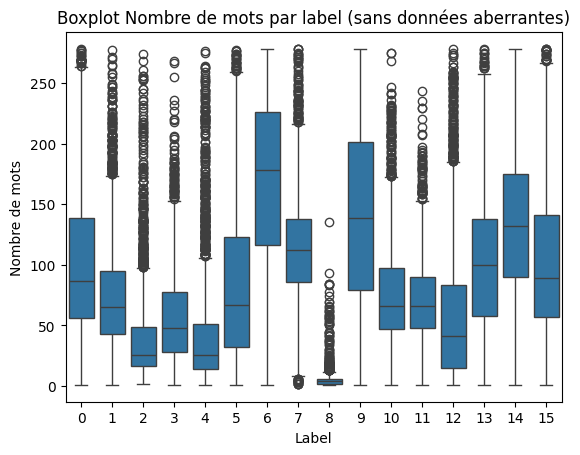

,count,mean,std,min,25%,50%,75%,max
label,,,,,,,,
0,3135.0,102.290909,59.661678,1.0,56.0,87.0,139.0,278.0
1,3163.0,75.226051,44.982600,1.0,43.0,65.0,95.0,277.0
2,3116.0,39.677471,36.851447,2.0,17.0,26.0,49.0,274.0
3,3214.0,56.471375,38.071880,1.0,28.0,48.0,78.0,268.0
4,3054.0,42.482646,46.414031,1.0,14.0,26.0,51.0,276.0
5,3058.0,84.043165,64.240242,1.0,32.0,66.5,123.0,277.0
6,1992.0,164.921687,75.919403,1.0,116.0,178.0,226.0,278.0
7,3103.0,114.320980,43.421392,2.0,86.0,112.0,138.0,278.0
8,3054.0,5.292403,7.538261,1.0,2.0,4.0,6.0,135.0


In [6]:
#Boxplot Nombre de mots par label sans données aberrantes
sns.boxplot(x='label', y='easyocr_text_nbr', data=df)

# Ajouter un titre au graphique
plt.title('Boxplot Nombre de mots par label (sans données aberrantes)')

# Ajouter des labels pour les axes
plt.xlabel('Label')
plt.ylabel('Nombre de mots')

# Afficher le graphique
plt.show()

# Statistiques
df.groupby('label')['easyocr_text_nbr'].describe()

In [7]:
#Convertir les mots en minuscules
df['easyocr_text_cleaned'] = df['easyocr_text'].apply(lambda x: ' '.join(x).lower() if isinstance(x, list) else str(x).lower())

#Fonction pour enlever la ponctuation
def remove_punctuation(text):
    return text.translate(str.maketrans('', '', string.punctuation))

#Appliquer la suppression de la ponctuation
df['easyocr_text_cleaned'] = df['easyocr_text_cleaned'].apply(remove_punctuation)

#Fonction pour supprimer les espaces superflus
def remove_extra_spaces(text):
    return ' '.join(text.split())

#Appliquer la suppression des espaces superflus :
#espaces multiples entre les mots et des espaces au début et à la fin.
df['easyocr_text_cleaned'] = df['easyocr_text_cleaned'].apply(remove_extra_spaces)

import re

#Fonction pour supprimer les séquences indésirables
def clean_special_chars_and_numbers(text):
    #re.sub(modèle, remplacement, chaîne)
    #Supprimer les caractères spéciaux
    text = re.sub(r'[^\w\s]', '', text)
    return text

#Nettoyer les données
df['easyocr_text_cleaned'] = df['easyocr_text_cleaned'].apply(clean_special_chars_and_numbers)

#Gestion des valeurs manquantes
print("Gestion de Nan ", df.isna().sum())
#Gestion des doublons
print("Gestion des doublons ", df.duplicated(subset=['file_name']).sum())

Gestion de Nan  file_name               0
label                   0
easyocr_text            0
easyocr_text_nbr        0
easyocr_text_cleaned    0
dtype: int64
Gestion des doublons  0


In [8]:
#Tokenniser : découper le texte en mot.
from nltk.tokenize import word_tokenize
df["easyocr_text_token"] = df["easyocr_text_cleaned"].apply(word_tokenize)

#Calculer le nombre de mots
df["easyocr_text_token_nbr"] = df["easyocr_text_token"].apply(len)

In [9]:
#STOP WORD
from nltk.corpus import stopwords
# Initialiser la variable des mots vides
stop_words = set(stopwords.words('english'))
#Ajouter des mots vides
add_stopwords = ['*']  # List for multiple words
stop_words.update(add_stopwords)  # Add the whole list at once

df['easyocr_text_token_stop_words'] = df['easyocr_text_token'].apply(lambda x: [word for word in x if word.lower() not in stop_words])

#LEMMATISATION
wordnet_lemmatizer = WordNetLemmatizer()
def lemmatize_word_list(word_list):
  lemmatized_list = [wordnet_lemmatizer.lemmatize(word) for word in word_list]
  return lemmatized_list

# Appliquer la fonction à la colonne 'token_count_no_stopwords'
df['easyocr_text_token_stop_words_lemmatized'] = df['easyocr_text_token_stop_words'].apply(lemmatize_word_list)
df['easyocr_text_token_stop_words_lemmatized_nbr'] = df.easyocr_text_token_stop_words_lemmatized.str.len()

In [11]:
df.head()

,file_name,label,easyocr_text,easyocr_text_nbr,easyocr_text_cleaned,easyocr_text_token,easyocr_text_token_nbr,easyocr_text_token_stop_words,easyocr_text_token_stop_words_lemmatized,easyocr_text_token_stop_words_lemmatized_nbr
0,imagesq/q/o/c/qoc54c00/80035521.tif,15,"[~Conillard, MEMORANDUM, May, 12 ,, 1986, Heck...",54,conillard memorandum may 12 1986 heck froh dea...,"[conillard, memorandum, may, 12, 1986, heck, f...",60,"[conillard, memorandum, may, 12, 1986, heck, f...","[conillard, memorandum, may, 12, 1986, heck, f...",49
1,imagese/e/w/c/ewc23d00/513280028.tif,1,"[Tod? 0~DZ, DOCUHENT_CLEARANCE_SHEEL, (For, Or...",89,tod 0dz docuhentclearancesheel for original co...,"[tod, 0dz, docuhentclearancesheel, for, origin...",136,"[tod, 0dz, docuhentclearancesheel, original, c...","[tod, 0dz, docuhentclearancesheel, original, c...",120
2,imagesw/w/b/t/wbt26e00/2053453161.tif,7,"[CIGBRELIE, SPECLELCALLON, CABARRUS, CountY, E...",157,cigbrelie speclelcallon cabarrus county effect...,"[cigbrelie, speclelcallon, cabarrus, county, e...",211,"[cigbrelie, speclelcallon, cabarrus, county, e...","[cigbrelie, speclelcallon, cabarrus, county, e...",203
3,imagesm/m/k/m/mkm05e00/2040792992_2040792994.tif,10,"[LEO BURNETT U.S.4., nivsion or Lco, ILHY, cuk...",82,leo burnett us4 nivsion or lco ilhy cuktnyirc ...,"[leo, burnett, us4, nivsion, or, lco, ilhy, cu...",95,"[leo, burnett, us4, nivsion, lco, ilhy, cuktny...","[leo, burnett, us4, nivsion, lco, ilhy, cuktny...",93
4,imageso/o/e/x/oex80d00/522787731+-7732.tif,3,"[W, 8, H, K, 0, 6, , 0, R, 1, 8, 11, 1, , 5, 0...",19,w 8 h k 0 6 0 r 1 8 11 1 5 01 1 1 1,"[w, 8, h, k, 0, 6, 0, r, 1, 8, 11, 1, 5, 01, 1...",17,"[w, 8, h, k, 0, 6, 0, r, 1, 8, 11, 1, 5, 01, 1...","[w, 8, h, k, 0, 6, 0, r, 1, 8, 11, 1, 5, 01, 1...",17


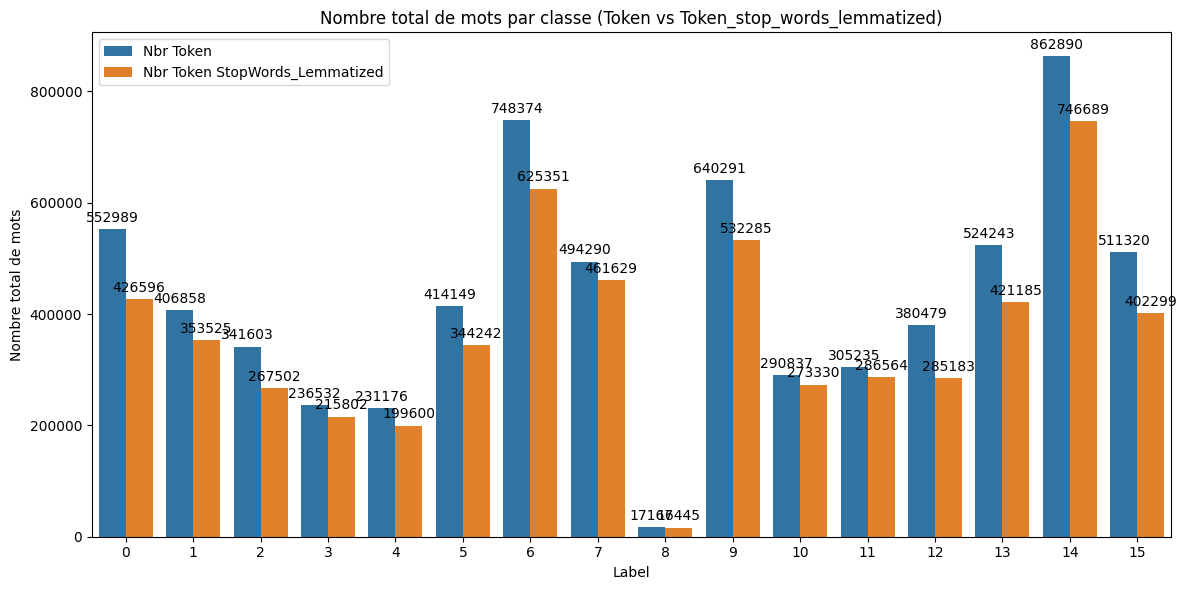

In [12]:
"""
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
"""
# Regrouper les données
df1 = df.groupby('label')['easyocr_text_token_nbr'].sum().reset_index()
df2 = df.groupby('label')['easyocr_text_token_stop_words_lemmatized_nbr'].sum().reset_index()

# Fusionner les deux DataFrames sur 'label'
df_combined = pd.merge(df1, df2, on='label')
df_melted = pd.melt(
    df_combined,
    id_vars='label',
    value_vars=['easyocr_text_token_nbr', 'easyocr_text_token_stop_words_lemmatized_nbr'],
    var_name='Type',
    value_name='Nombre de mots'
)

# Renommer les types pour affichage clair
df_melted['Type'] = df_melted['Type'].replace({
    'easyocr_text_token_nbr': 'Nbr Token',
    'easyocr_text_token_stop_words_lemmatized_nbr': 'Nbr Token StopWords_Lemmatized'
})

# Tracer le graphique à barres groupées
plt.figure(figsize=(12, 6))
ax = sns.barplot(data=df_melted, x='label', y='Nombre de mots', hue='Type')

# Ajouter les valeurs au-dessus des barres
for container in ax.containers:
    ax.bar_label(container, fmt='%d', label_type='edge', padding=3)

# Titre et axes
plt.title("Nombre total de mots par classe (Token vs Token_stop_words_lemmatized)")
plt.xlabel("Label")
plt.ylabel("Nombre total de mots")
plt.legend(title="")

plt.tight_layout()
plt.show()

In [ ]:
print(df.easyocr_text_token_stop_words)

0        [conillard, memorandum, may, 12, 1986, heck, f...
1        [tod, 0dz, docuhentclearancesheel, original, c...
2        [cigbrelie, speclelcallon, cabarrus, county, e...
3        [leo, burnett, us4, nivsion, lco, ilhy, cuktny...
4        [w, 8, h, k, 0, 6, 0, r, 1, 8, 11, 1, 5, 01, 1...
                               ...                        
49995    [material, safety, datasheet, product, name, m...
49996    [orlalnal, vessage, clikin, kari, fent, fopky,...
49997    [march, 20, 1987, rur, secret, addressee, hr, ...
49998    [arung, surqu, ganersl, deleltures, ic, garell...
49999                                               [8, 1]
Name: easyocr_text_token_stop_words, Length: 47206, dtype: object


In [13]:
df_label= df[df['label'].between(0,15)]

# Creer un nuage de mots pour chaque label
for label in df_label['label'].unique():
    texte = ' '.join(df_label[df_label['label'] == label]['easyocr_text_token_stop_words'].astype(str))

    # Creer le nuage de mots
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(texte)
     # Afficher le nuage de mots
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(f'Nuage de mots pour le label {label}')
    plt.axis('off')
    plt.show()


Output hidden; open in https://colab.research.google.com to view.

In [14]:
#PREDICTION
from sklearn.model_selection import train_test_split
# Séparer la variable explicative de la variable à prédire
X, y = df.easyocr_text_token_stop_words_lemmatized,df.label

# Séparer le jeu de données en données d'entraînement et données test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 30)

In [15]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
# Créer un vectorisateur
vec_stem = TfidfVectorizer()

X_train = X_train.astype(str)
X_test = X_test.astype(str)

# Mettre à jour la valeur de X_train_stem et X_test_stem
X_train = vec_stem.fit_transform(X_train)
X_test = vec_stem.transform(X_test)

In [16]:
from sklearn import linear_model
lr = linear_model.LogisticRegression(C=10,solver='lbfgs').fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [17]:
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(y_test, y_pred_lr)
print(f"Accuracy: {accuracy}")

Accuracy: 0.7445828535538574


In [19]:
from sklearn.metrics import classification_report
# Calcul et affichage de classification_report
print(classification_report(y_test, y_pred_lr) )

# Calcul et affichage de la matrice de confusion
conf_matrix_stem = pd.crosstab(y_test, y_pred_lr, rownames=['Classe réelle'], colnames=['Classe prédite'])
conf_matrix_stem

              precision    recall  f1-score   support

           0       0.77      0.69      0.72       649
           1       0.73      0.67      0.70       605
           2       0.93      0.88      0.91       605
           3       0.60      0.76      0.67       628
           4       0.75      0.62      0.68       629
           5       0.73      0.68      0.70       576
           6       0.78      0.82      0.80       377
           7       0.93      0.84      0.88       627
           8       0.56      0.89      0.69       603
           9       0.61      0.72      0.66       481
          10       0.72      0.70      0.71       655
          11       0.77      0.76      0.76       621
          12       0.63      0.51      0.56       648
          13       0.84      0.73      0.78       582
          14       0.96      0.92      0.94       664
          15       0.78      0.75      0.76       603

    accuracy                           0.74      9553
   macro avg       0.76   

Classe prédite,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
Classe réelle,,,,,,,,,,,,,,,,
0,446,21,11,26,6,9,5,4,12,15,10,10,16,6,2,50
1,18,406,5,20,8,18,6,12,17,12,22,28,9,11,1,12
2,13,6,533,4,4,2,1,1,9,6,5,2,10,3,0,6
3,11,3,0,478,22,7,1,2,60,7,8,6,10,9,0,4
4,5,12,0,45,391,5,4,0,77,37,17,13,12,10,0,1
5,8,25,1,22,5,391,27,6,23,10,17,4,18,2,7,10
6,0,2,0,6,2,16,309,1,8,20,1,1,4,2,5,0
7,5,6,1,27,4,11,1,528,8,6,9,8,4,4,0,5
8,2,7,0,12,7,4,0,1,537,7,5,6,10,2,2,1


In [21]:
from sklearn.ensemble import RandomForestClassifier

rf_classifier = RandomForestClassifier(max_depth=30, n_estimators=200).fit(X_train, y_train)
y_pred_rf = rf_classifier.predict(X_test)


In [22]:
accuracy = accuracy_score(y_test, y_pred_rf)
print(f"Accuracy: {accuracy}")

Accuracy: 0.6340416623050351


In [23]:
from sklearn.metrics import classification_report
# Calcul et affichage de classification_report
print(classification_report(y_test, y_pred_rf) )

# Calcul et affichage de la matrice de confusion
conf_matrix_stem = pd.crosstab(y_test, y_pred_rf, rownames=['Classe réelle'], colnames=['Classe prédite'])
conf_matrix_stem

              precision    recall  f1-score   support

           0       0.74      0.56      0.64       649
           1       0.78      0.57      0.66       605
           2       0.79      0.87      0.83       605
           3       0.31      0.64      0.42       628
           4       0.77      0.42      0.55       629
           5       0.73      0.53      0.62       576
           6       0.84      0.58      0.68       377
           7       0.84      0.83      0.83       627
           8       0.33      0.97      0.49       603
           9       0.77      0.39      0.52       481
          10       0.79      0.49      0.61       655
          11       0.77      0.65      0.70       621
          12       0.75      0.29      0.42       648
          13       0.78      0.70      0.74       582
          14       0.82      0.94      0.88       664
          15       0.70      0.66      0.68       603

    accuracy                           0.63      9553
   macro avg       0.72   

Classe prédite,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
Classe réelle,,,,,,,,,,,,,,,,
0,366,19,23,50,5,15,2,12,25,1,4,14,4,8,12,89
1,10,345,16,44,5,18,3,25,62,0,12,32,2,6,5,20
2,8,3,525,13,2,4,1,1,19,9,1,1,5,4,1,8
3,15,3,7,399,11,1,0,3,159,2,6,6,1,15,0,0
4,4,4,13,106,266,0,2,0,181,14,3,5,10,21,0,0
5,4,20,3,71,8,305,19,30,70,0,4,4,0,1,29,8
6,0,2,0,46,4,22,218,0,31,5,1,0,1,2,44,1
7,0,5,3,61,1,3,1,518,27,0,0,1,0,3,0,4
8,0,0,4,12,2,1,0,0,582,0,0,2,0,0,0,0
